### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import tensorflow as tf
tf.__version__

'2.5.1'

In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, RMSPropOptimizer
from pennylane import numpy as np
from pennylane.templates.layers import CVNeuralNetLayers
import strawberryfields as sf

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [6]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [7]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

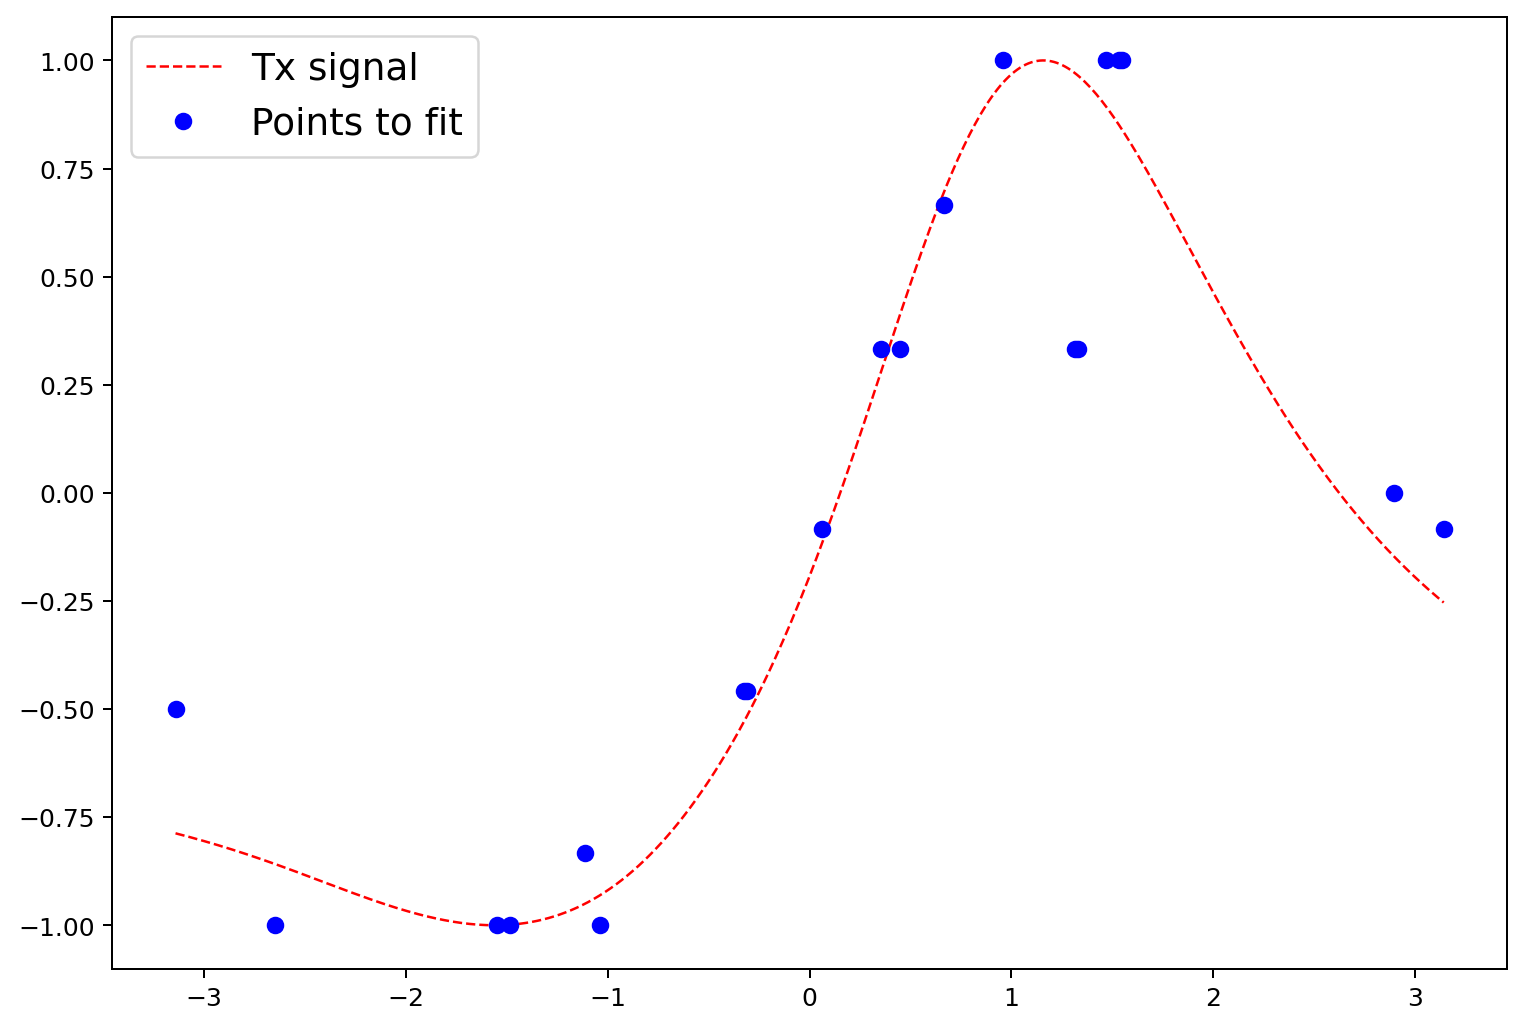

In [9]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [10]:
#TOKEN = ""

In [11]:
#import xcc

#settings = xcc.Settings(REFRESH_TOKEN=TOKEN)
#settings.save()

In [12]:
num_qubits = 1

In [13]:
#dev = qml.device("strawberryfields.tf", wires=num_qubits)

#dev = qml.device('default.gaussian', wires=num_qubits)
dev = qml.device("strawberryfields.tf", wires=1, cutoff_dim=10)

#dev = qml.device('strawberryfields.remote', backend="X8", shots=10, sf_token=TOKEN)

In [14]:
def layer(v):
    qml.CVNeuralNetLayers(*v, wires=list(range(num_qubits)))
    #qml.Rotation(v[0], wires=0)
    #qml.Squeezing(v[1], 0.0, wires=0)
    #qml.Rotation(v[2], wires=0)
    # Bias
    #qml.Displacement(v[3], 0.0, wires=0)
    # Element-wise nonlinear transformation
    #qml.Kerr(v[4], wires=0) 

In [15]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    
    # Encode input x into quantum state
    for i in range(num_qubits):
        #qml.Rotation(x, wires=i)
        qml.Displacement(x, 0.0, wires=i)
    
    layer(var)

    return qml.expval(qml.X(0))

In [16]:
def square_loss(labels, predictions):
    
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    
    return loss

In [17]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [18]:
#np.random.seed(0)
#num_layers = 4
#weights = 0.05 * np.random.randn(num_layers, 5, requires_grad=True)

#print(weights)

In [19]:
np.random.seed(0)

shapes = CVNeuralNetLayers.shape(n_layers=3, n_wires=num_qubits)
weights = [np.random.random(shape) for shape in shapes]

#print(weights)

In [20]:
X_data = X.numpy()[:, 0]
y_data = y.numpy()[:, 0]

In [21]:
opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)
#opt = GradientDescentOptimizer(stepsize=0.01)
#opt = RMSPropOptimizer(stepsize=0.01,decay=0.9)

cost_plot = []
var = weights

(<Figure size 1368x144 with 1 Axes>, <Axes:>)


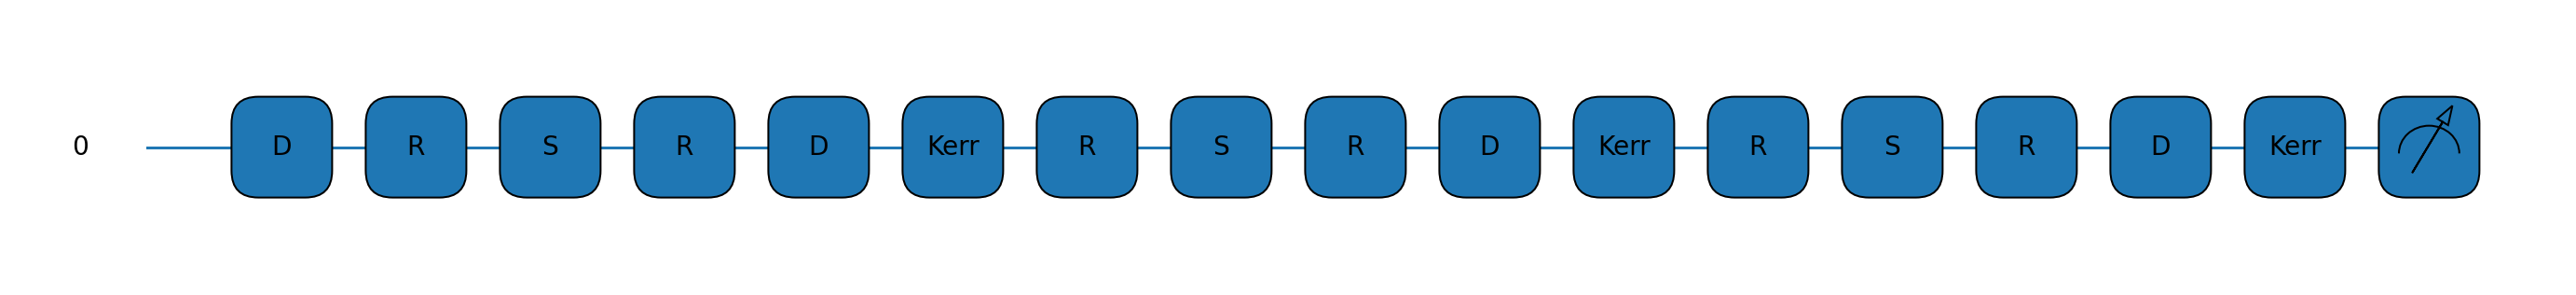

In [22]:
print(qml.draw_mpl(quantum_neural_net, expansion_strategy="device")(var, X_data))

In [23]:
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.1810858 
Iter:     1 | Cost: 0.1827503 
Iter:     2 | Cost: 0.1371149 
Iter:     3 | Cost: 0.1474880 
Iter:     4 | Cost: 0.1869622 
Iter:     5 | Cost: 0.2117945 
Iter:     6 | Cost: 0.1968798 
Iter:     7 | Cost: 0.1800708 
Iter:     8 | Cost: 0.1765796 
Iter:     9 | Cost: 0.1468870 
Iter:    10 | Cost: 0.1947040 
Iter:    11 | Cost: 0.1423627 
Iter:    12 | Cost: 0.1969156 
Iter:    13 | Cost: 0.1979804 
Iter:    14 | Cost: 0.1446713 
Iter:    15 | Cost: 0.1588545 
Iter:    16 | Cost: 0.2068181 
Iter:    17 | Cost: 0.1408929 
Iter:    18 | Cost: 0.1769758 
Iter:    19 | Cost: 0.2113446 
Iter:    20 | Cost: 0.1419847 
Iter:    21 | Cost: 0.1785419 
Iter:    22 | Cost: 0.1891868 
Iter:    23 | Cost: 0.2338693 
Iter:    24 | Cost: 0.1881690 
Iter:    25 | Cost: 0.2157866 
Iter:    26 | Cost: 0.1410581 
Iter:    27 | Cost: 0.2195873 
Iter:    28 | Cost: 0.1682721 
Iter:    29 | Cost: 0.1679729 
Iter:    30 | Cost: 0.1747529 
Iter:    31 | Cost: 0.1581671 
Iter:   

Iter:   265 | Cost: 0.1786343 
Iter:   266 | Cost: 0.2672954 
Iter:   267 | Cost: 0.1401238 
Iter:   268 | Cost: 0.2103453 
Iter:   269 | Cost: 0.2330341 
Iter:   270 | Cost: 0.1822365 
Iter:   271 | Cost: 0.1667975 
Iter:   272 | Cost: 0.1703464 
Iter:   273 | Cost: 0.1755247 
Iter:   274 | Cost: 0.2200383 
Iter:   275 | Cost: 0.2183591 
Iter:   276 | Cost: 0.1529117 
Iter:   277 | Cost: 0.2346579 
Iter:   278 | Cost: 0.1758819 
Iter:   279 | Cost: 0.1377765 
Iter:   280 | Cost: 0.1364208 
Iter:   281 | Cost: 0.1517724 
Iter:   282 | Cost: 0.1591201 
Iter:   283 | Cost: 0.1916640 
Iter:   284 | Cost: 0.2160080 
Iter:   285 | Cost: 0.1327648 
Iter:   286 | Cost: 0.1984783 
Iter:   287 | Cost: 0.1377767 
Iter:   288 | Cost: 0.1688661 
Iter:   289 | Cost: 0.1869437 
Iter:   290 | Cost: 0.1739274 
Iter:   291 | Cost: 0.1685282 
Iter:   292 | Cost: 0.1695162 
Iter:   293 | Cost: 0.1604576 
Iter:   294 | Cost: 0.2168944 
Iter:   295 | Cost: 0.1617820 
Iter:   296 | Cost: 0.1520461 
Iter:   

In [24]:
for _ in range(2):

    shapes = CVNeuralNetLayers.shape(n_layers=3, n_wires=num_qubits)
    weights = [np.random.random(shape) for shape in shapes]  
    var = weights
    
    #np.random.seed(0)
    #num_layers = 4
    #weights = 0.05 * np.random.randn(num_layers, 5, requires_grad=True)
    #var = weights

    for it in range(500):
        (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
        cost_plot.append(_cost)
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, _cost))
        #if cost(var1, X_data, y_data)<0.1:
        #    opt.update_stepsize(0.005)

Iter:     1 | Cost: 0.7778291 
Iter:     2 | Cost: 0.6397050 
Iter:     3 | Cost: 0.7482081 
Iter:     4 | Cost: 0.6409492 
Iter:     5 | Cost: 0.7709112 
Iter:     6 | Cost: 0.8040227 
Iter:     7 | Cost: 0.8413594 
Iter:     8 | Cost: 0.7400213 
Iter:     9 | Cost: 0.7130893 
Iter:    10 | Cost: 0.8396837 
Iter:    11 | Cost: 0.7306543 
Iter:    12 | Cost: 0.6566539 
Iter:    13 | Cost: 0.6421285 
Iter:    14 | Cost: 0.6869515 
Iter:    15 | Cost: 0.7268644 
Iter:    16 | Cost: 0.7457337 
Iter:    17 | Cost: 0.6707204 
Iter:    18 | Cost: 0.7979694 
Iter:    19 | Cost: 0.7621934 
Iter:    20 | Cost: 0.8025943 
Iter:    21 | Cost: 0.7871257 
Iter:    22 | Cost: 0.7443209 
Iter:    23 | Cost: 0.8595732 
Iter:    24 | Cost: 0.7358984 
Iter:    25 | Cost: 0.6774556 
Iter:    26 | Cost: 0.7465650 
Iter:    27 | Cost: 0.8438656 
Iter:    28 | Cost: 0.6849044 
Iter:    29 | Cost: 0.8588797 
Iter:    30 | Cost: 0.6644365 
Iter:    31 | Cost: 0.8666265 
Iter:    32 | Cost: 0.7320701 
Iter:   

Iter:   266 | Cost: 0.7498770 
Iter:   267 | Cost: 0.5454216 
Iter:   268 | Cost: 0.8022019 
Iter:   269 | Cost: 0.9300570 
Iter:   270 | Cost: 0.6313292 
Iter:   271 | Cost: 0.8320251 
Iter:   272 | Cost: 0.7058217 
Iter:   273 | Cost: 0.8565277 
Iter:   274 | Cost: 0.6065348 
Iter:   275 | Cost: 0.8937764 
Iter:   276 | Cost: 0.6269932 
Iter:   277 | Cost: 0.7713192 
Iter:   278 | Cost: 0.6038646 
Iter:   279 | Cost: 0.8354869 
Iter:   280 | Cost: 0.7172627 
Iter:   281 | Cost: 0.8105032 
Iter:   282 | Cost: 0.8295153 
Iter:   283 | Cost: 0.7113293 
Iter:   284 | Cost: 0.7142720 
Iter:   285 | Cost: 0.7525575 
Iter:   286 | Cost: 0.8056920 
Iter:   287 | Cost: 0.7538762 
Iter:   288 | Cost: 0.7056264 
Iter:   289 | Cost: 0.8172130 
Iter:   290 | Cost: 0.7652472 
Iter:   291 | Cost: 0.8305330 
Iter:   292 | Cost: 0.8423055 
Iter:   293 | Cost: 0.7226314 
Iter:   294 | Cost: 0.6530402 
Iter:   295 | Cost: 0.7827075 
Iter:   296 | Cost: 0.8830145 
Iter:   297 | Cost: 0.8497278 
Iter:   

Iter:    31 | Cost: 0.2256458 
Iter:    32 | Cost: 0.1852684 
Iter:    33 | Cost: 0.2413033 
Iter:    34 | Cost: 0.2212212 
Iter:    35 | Cost: 0.2228802 
Iter:    36 | Cost: 0.2237777 
Iter:    37 | Cost: 0.2059435 
Iter:    38 | Cost: 0.1730816 
Iter:    39 | Cost: 0.1567985 
Iter:    40 | Cost: 0.1762820 
Iter:    41 | Cost: 0.2053667 
Iter:    42 | Cost: 0.2614421 
Iter:    43 | Cost: 0.2771465 
Iter:    44 | Cost: 0.1904094 
Iter:    45 | Cost: 0.1845851 
Iter:    46 | Cost: 0.1858088 
Iter:    47 | Cost: 0.2232296 
Iter:    48 | Cost: 0.2220779 
Iter:    49 | Cost: 0.1693473 
Iter:    50 | Cost: 0.2590700 
Iter:    51 | Cost: 0.1683153 
Iter:    52 | Cost: 0.2745690 
Iter:    53 | Cost: 0.1915832 
Iter:    54 | Cost: 0.2257347 
Iter:    55 | Cost: 0.1743767 
Iter:    56 | Cost: 0.2020462 
Iter:    57 | Cost: 0.1710083 
Iter:    58 | Cost: 0.1469826 
Iter:    59 | Cost: 0.2007118 
Iter:    60 | Cost: 0.1934837 
Iter:    61 | Cost: 0.1833101 
Iter:    62 | Cost: 0.1381336 
Iter:   

Iter:   296 | Cost: 0.2226735 
Iter:   297 | Cost: 0.1525760 
Iter:   298 | Cost: 0.2269130 
Iter:   299 | Cost: 0.2994333 
Iter:   300 | Cost: 0.2905177 
Iter:   301 | Cost: 0.2725494 
Iter:   302 | Cost: 0.3597846 
Iter:   303 | Cost: 0.1876198 
Iter:   304 | Cost: 0.1226108 
Iter:   305 | Cost: 0.2121807 
Iter:   306 | Cost: 0.1736322 
Iter:   307 | Cost: 0.1513952 
Iter:   308 | Cost: 0.2069186 
Iter:   309 | Cost: 0.2408810 
Iter:   310 | Cost: 0.1847812 
Iter:   311 | Cost: 0.1783160 
Iter:   312 | Cost: 0.1890542 
Iter:   313 | Cost: 0.2863359 
Iter:   314 | Cost: 0.1887331 
Iter:   315 | Cost: 0.2483043 
Iter:   316 | Cost: 0.1699425 
Iter:   317 | Cost: 0.2066370 
Iter:   318 | Cost: 0.2231714 
Iter:   319 | Cost: 0.2097084 
Iter:   320 | Cost: 0.2205387 
Iter:   321 | Cost: 0.1902467 
Iter:   322 | Cost: 0.1663150 
Iter:   323 | Cost: 0.2517821 
Iter:   324 | Cost: 0.2308143 
Iter:   325 | Cost: 0.2525266 
Iter:   326 | Cost: 0.2341774 
Iter:   327 | Cost: 0.1617658 
Iter:   

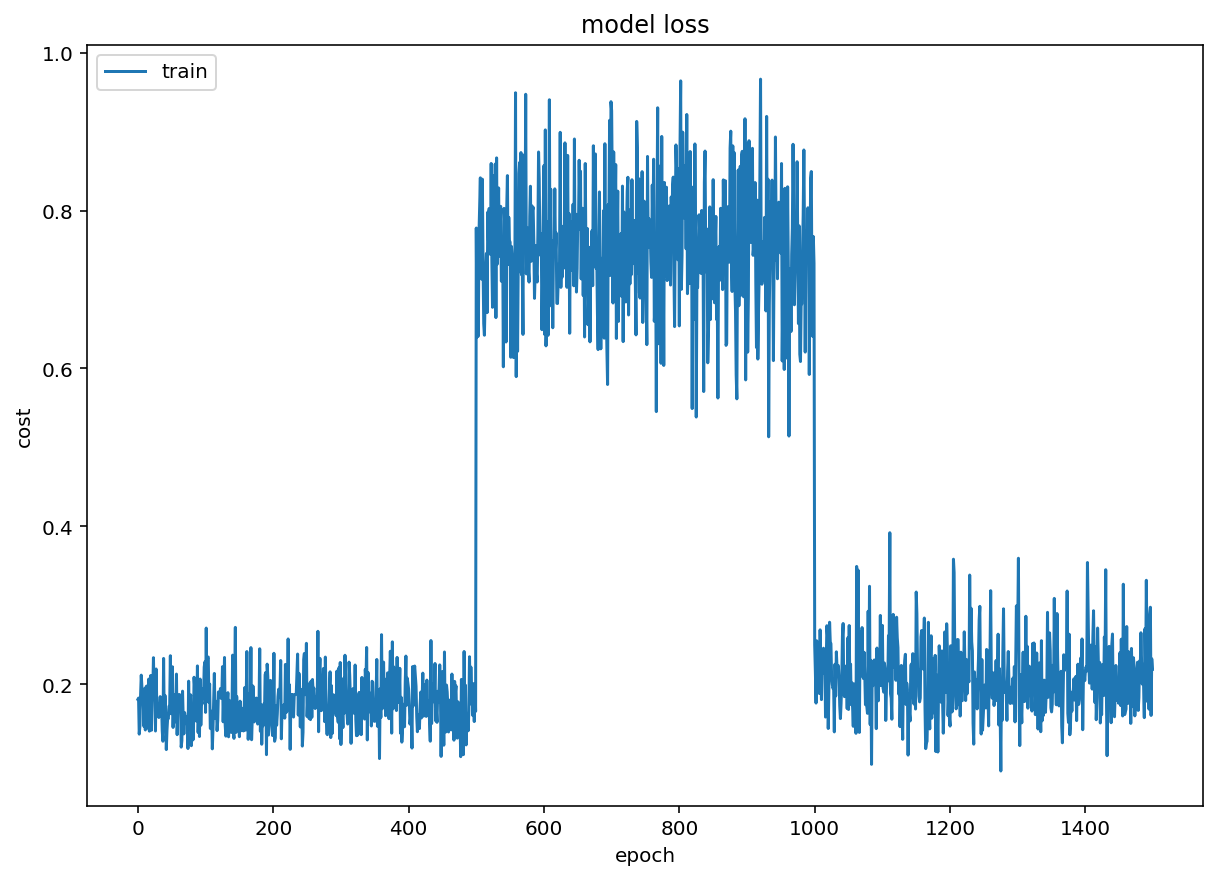

In [25]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

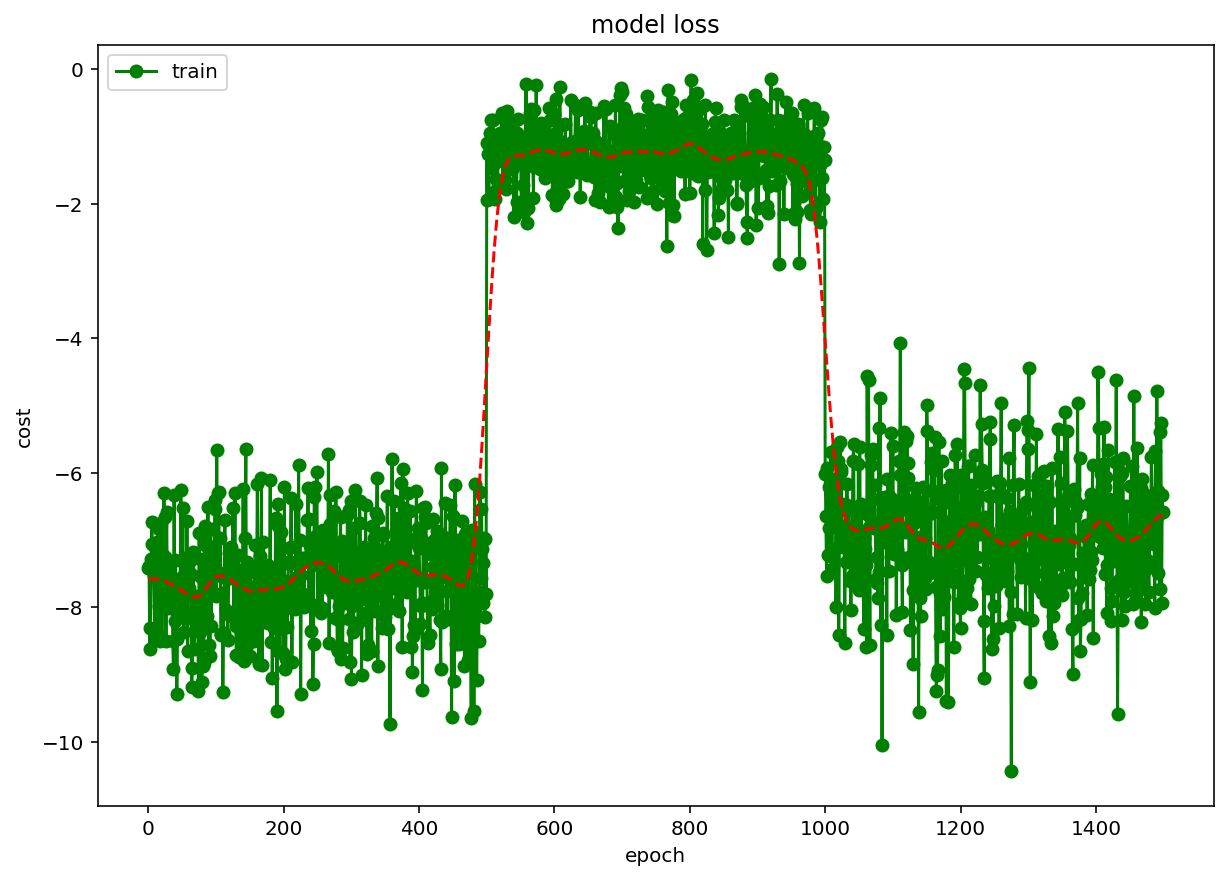

In [48]:
# summarize history for loss
plt.plot(10 * np.log10(cost_plot), 'o-', color = 'green')
plt.plot(smooth(10 * np.log10(cost_plot)), '--', color = 'red')
plt.title('model loss')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [27]:
X_pred = X_.numpy()[:,0]

y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

y_predict_smooth = smooth(y_predict)

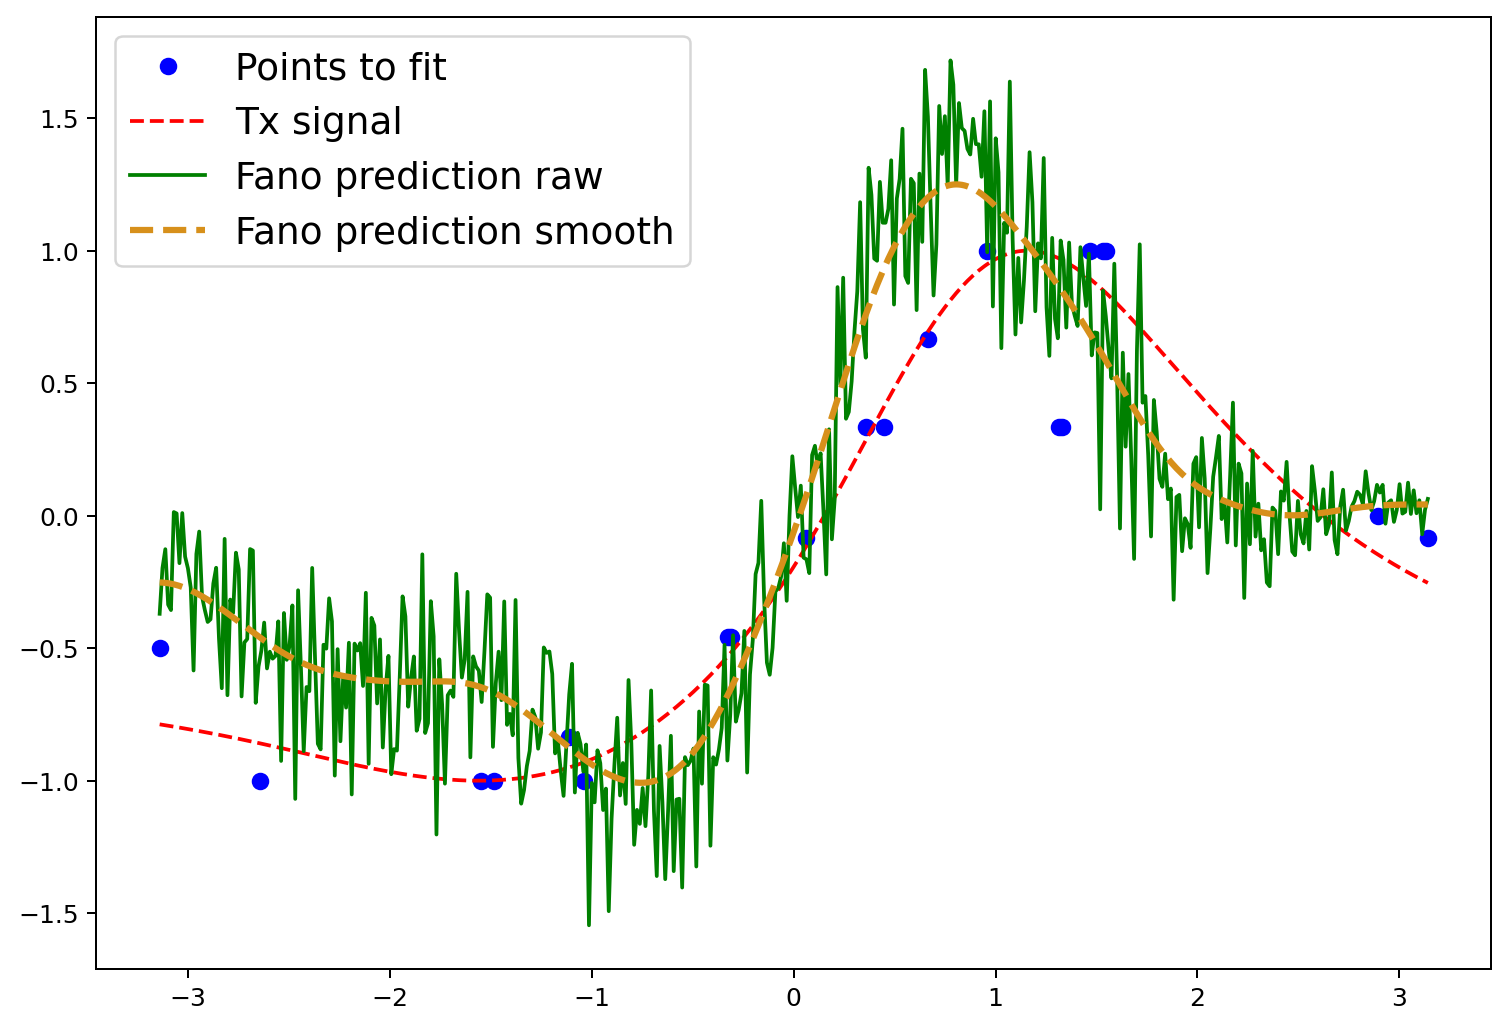

In [28]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [29]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.6770587322


In [30]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright